# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
In this project, your goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. The camera calibration images, test road images, and project videos are available in the project repository. 

## Import Packages

In [1]:
# importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits import mplot3d
import numpy as np
import cv2
%matplotlib inline

# My imports
from sklearn.cluster import KMeans
import collections
from collections import OrderedDict
from itertools import cycle

import os
from skimage.transform import radon, rescale
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy import signal

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


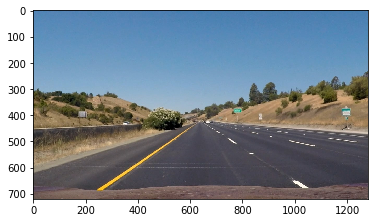

In [2]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Wrapper functions for convinience

In [3]:
def as_gray(img):
    """
    Takes in an image and returns it as grayscale
    :param img: Image to transform
    :return: Grayscale image
    """
    return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


def list_images(path):
    """
    Returns all files that are in a folder as a list with relative path
    :param path: Parent path
    :return: List of relative image paths
    """
    return [path + filename for filename in os.listdir(path)]


def as_3DPlot(image_channel, title='image channel as 3D', show=True):
    """
    Takes an image and plots it as 3D Plot, where the intesity is Z-Axis. It helps to understand the values of an image better.
    
    :param image_channel: An image channel, may only be one channel 
    :param title: The title of the plot defaults to generic title
    :param show: If the plot shall be shown directly, defaults to True
    :return: nothing
    """
    ax = plt.axes(projection='3d')
    xx, yy = np.mgrid[0:image_channel.shape[0], 0:image_channel.shape[1]]
    ax.contour3D(xx, yy, image_channel, 50, cmap='binary')
    ax.set_title(title);
    if show:
      plt.show()
    
    
def scale_distant_values(image, factor=3.5, order=2):
    """
    This function takes an image and multiplies values by up to 10. The idea is to 
    enhance detected edges found in BEV images, where the far lanes are less clear.
    As I assume this to be squared, I use a squared function. It never gets bigger than the biggest value.
    edges
    """
    max_val = np.max(image)
    dtype = image.dtype
    op_image = np.copy(image)
    for row in list(range(op_image.shape[0])):
        scaler = 1 + factor*(((op_image.shape[0]-row)/op_image.shape[0])**order)
        op_image[row, :] = np.minimum((op_image[row, :] * scaler), max_val)
    return op_image
    
    
def as_fft(image):
    """
    Returns an the magitude spectrum of a fourier transformation of the image.
    :param image: The source image
    :return: Spectrum image
    """
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    return magnitude_spectrum


def as_radon_trafo(image):
    """
    Returns a radon transformed image representation of the image.
    :param image: Image to transform
    :return: Radon transformed image
    """
    op_img = np.copy(image)
    rescaled_img = rescale(op_img, scale=0.25, mode='reflect', multichannel=False)
    theta = np.linspace(0., 180., max(rescaled_img.shape), endpoint=False)
    sinogram = radon(rescaled_img, theta=theta, circle=True)
    #sinogram //= ((np.max(sinogram) // 255))

    return sinogram


def as_opened(image, iterations=1, kernel=np.ones((4,6),np.uint8)):
    """
    "Opens" a binary image. See the following link for documentation of opening:
    
    https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
    
    :param image: Input image 
    :param iterations: The number of times the open operation shall be performed, defaults to 1
    :param kernel: The kernel as numpy array. Defaults to a lane like shape.
    :return: Opened image
    """
    # 
    op_image = np.copy(image)
    for i in range(iterations):
        op_image = cv2.morphologyEx(op_image, cv2.MORPH_OPEN, kernel) 
    return op_image 
 
    
def as_closed(image, iterations=1, kernel=np.ones((4,6),np.uint8)):
    """
    "Closes" a binary image. See the following link for documentation of closing:
    
    https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
    
    :param image: Input image 
    :param iterations: The number of times the open operation shall be performed, defaults to 1
    :param kernel: The kernel as numpy array. Defaults to a lane like shape.
    :return: Closed image
    """    
    op_image = np.copy(image)
    for i in range(iterations):
        op_image = cv2.morphologyEx(op_image, cv2.MORPH_CLOSE, kernel) 
    return op_image 


def smoothen(image, kernel=np.ones((9,9),np.float32)/(9*9)):
    """
    Non gaussian smoothing/averaging of an image
    :param image: Image to smoothen
    :param kernel: Kernel as numpy array. Defaults to equally distributed 9x9 kernel with magnitide 1/(9*9)
    :return: Smooth image
    """
    return cv2.filter2D(image,-1,kernel)


def radon_clusters(radon_img, thresh=0.25, plot=False):
    """
    This takes a radon image and find its peaks OR plots the peaks into the radon image. 
    This is used to classify lane extractions into usable and non-usable ones
     
    :param radon_img: The radon image created with as_radon() 
    :param thresh: A theshold for peaks. Values below this will not be considered as peaks. Defaults to 0.25
    :param plot: If the peaks shall be returned as list, or if the peaks shall be plotted into the image. 
    Does not do both.
    
    :return: Either a list of peaks or a manipulated version of the radon image with 
    peaks plotted. Use this for testing
    """
    peak_points = []
    
    radon = np.copy(radon_img)
    #print("Max_Val: ", np.max(radon))
    X_indices = np.nonzero(radon >= thresh)
    X_data = radon[X_indices].T
    X = np.column_stack([X_indices[0], X_indices[1], X_data])#.reshape(3,-1)
    try:
        bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        data_to_fit = X[:,:2]
        ms.fit(data_to_fit)

        labels = ms.labels_
        cluster_centers = ms.cluster_centers_

        labels_unique = np.unique(labels)
        n_clusters = len(labels_unique)
        #print("n_clusters", n_clusters)
        # Find maximum per cluster
        for cluster in range(n_clusters):
            cluster_points=X[labels==cluster]
            data_points = cluster_points[:,2]
            max_row = np.argmax(data_points)
            peak = cluster_points[max_row,:2]
            peak_points.append(peak)
            radon = cv2.circle(radon,(int(peak[1]), int(peak[0])), 25, 0.75, -1)
    except Exception as e:
            print(e)
    
    if plot:
        return radon
    return peak_points


def is_good_lanes(image, tolerance_border=20):
    """
    Takes an image and tells if this image is a good lane representation or a bad one. It works by
    investigating the peaks of the radon transformation
    
    :param image: The input image 
    :param tolerance_border: The border at the left and the right of the 
    radon transofration, in which the peaks are considered to be "at the edge". Lowering this value 
    makes the algorithm more "sceptical" and will likely deny more images to be good.
    
    :return: Bool: True if the image is good, False if bad 
    """
    radon = as_radon_trafo(image)
    #print("Max_Val good lanes: ", np.max(radon))
    peaks = radon_clusters(radon)
    #print("peaks:", peaks)
    #print("shape:", radon.shape)
    #print("Shall not be between:", tolerance_border, " and ", radon.shape[1] - tolerance_border)
    for peak in peaks:
        if tolerance_border < peak[1] < radon.shape[1] - tolerance_border:
            return False
    return True

def find_lanes_start(lane_image, border_mask=0):
    """
    Find the startig x-positions of lanes in an image. Works by creating a 
    histogram over the lower half of the image
    
    :param lane_image: Image that hopefully contains lanes 
    :param border_mask: A mask to ignore parts at the left and right, and in the center of the image. Use with care. 
    Value is in pixels
    :return: List of two X-positions. [left_start_x, right_start_x]
    """
    # Cut bottom half
    bottom_half = lane_image[lane_image.shape[0]//2:,:]
    #plt.imshow(bottom_half)
    #plt.show()
    # Mask the half. In the lower part of the lanes image, the borders carry no useful information. These will be deleted
    if border_mask > 0:
        mask = np.ones_like(bottom_half)
        mask[:,:border_mask] = 0
        mask[:,-border_mask:] = 0
        mid = mask.shape[1] // 2
        mask[:,mid-border_mask:mid+border_mask] = 0
        #plt.imshow(mask)
        #plt.show()
        bottom_half[mask==0] = 0
        

    #plt.imshow(bottom_half)
    #plt.show()
    
    hist = np.sum(bottom_half, axis=0)
    
    #plt.plot(hist)
    #plt.show()
    #print(hist)
    #peaks_x = signal.find_peaks(hist, distance=30.)
    midpoint = np.int(hist.shape[0]//2)
    
    left_start = np.argmax(hist[:midpoint])
    right_start = np.argmax(hist[midpoint:]) + midpoint
    
    #print("L ", left_start," R ", right_start )
    return left_start, right_start
    
    
def find_lane_pixels(lane_image, sensitive=False):
    """
    More or less adapted from the lectures. Classifies pixels to be part of lanes. Works by a sliding window that
    sequentially follows the lanes and classifies the pixels
        
    :param lane_image: An image containing a lane 
    
    :param sensitive: If true, this function tunes its params to be more sensitve. 
    Use this if no lanes could be found in default settings in e.g. a second iteration.
     
    :return: The left and right pixels and and output image for testing 
    """

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 70

    # Set minimum number of pixels found to recenter window    
    if not sensitive:
        minpix = 40
        border_mask_size = 0#lane_image.shape[0] // 7
    else: # Sensitive mode
        minpix = 20
        border_mask_size = 0
    
    

    out_img = np.dstack((lane_image, lane_image, lane_image)).astype(np.float32)

    
    left_start, right_start = find_lanes_start(lane_image, border_mask_size)

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(lane_image.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = lane_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = left_start
    rightx_current = right_start

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = lane_image.shape[0] - (window+1)*window_height
        win_y_high = lane_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 7) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(255,0,0), 7) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    #plt.imshow(out_img)
    #plt.show()
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, last_polys=None, out_image=None):
    """
    Takes in pixels classified to be either of left or right lane 
    and tries to find a polynomial that best describes the pixels 
    
    :param binary_warped: A binary image in a Birds Eye View perspective 
    :param last_polys: An optional last set of polynomials that was found for the last image
    :param out_image: An output image that contains information of what the algorithm found for testing
    :return: left_fit, right_fit, ploty, out_img. The *_fit are the polynomials. The ploty are 
    the corresponding y-values for plotting and 
    interpreting the polynomials. Out image is the results image for testing
    """
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    if last_polys is None:
        # Find our lane pixels first
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
        # If nothing was found, try once more with more sensitive setting
        if any(len(i)==0 for i in [leftx, lefty, rightx, righty]):
            leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, sensitive=True)
        # If problem persists, return nothing and give up for this frame
        if any(len(i)==0 for i in [leftx, lefty, rightx, righty]):
            return None, None, ploty, out_img
        #print("Last polys not provided")
    else:
        leftx, lefty, rightx, righty = last_polys
        assert(out_image is not None)
        out_img = out_image
        #print("Last polys provided")
    
    #print("Left y, x: ", lefty, leftx)
    #print("Right y, x: ", righty, rightx)
    # Fit a second order polynomial to each using `np.polyfit`
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='blue')
    plt.plot(right_fitx, ploty, color='green')

    return left_fit, right_fit, ploty, out_img


def search_around_poly(binary_warped, left_fit=None, right_fit=None):
    """
    Calls the above functions and takes optionally the already found polynomials.
    
    :param binary_warped: Binary image 
    :param left_fit: Previously found left polynomial. If not provided this will be searched for in the pixels
    :param right_fit: Previously found right polynomial. If not provided this will be searched for in the pixels 
    :return: left_fit, right_fit, ploty, window_img: he *_fit are the polynomials. The ploty are 
    the corresponding y-values for plotting and 
    interpreting the polynomials. Out image is the results image for testing
    """
    
    if left_fit is None or right_fit is None:
        left_fit, right_fit, ploty, out_img = fit_polynomial(binary_warped)
        # Check if problem persists:
        if left_fit is None or right_fit is None:
            return None, None, ploty, out_img            

    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 70
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.float32)
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, ploty, out_img = fit_polynomial(binary_warped, (leftx, lefty, rightx, righty), out_img)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='blue')
    plt.plot(right_fitx, ploty, color='green')
    ## End visualization steps ##
    
    return left_fit, right_fit, ploty, window_img

## Test Utility functions
This is just a testing field cell and can be ignored

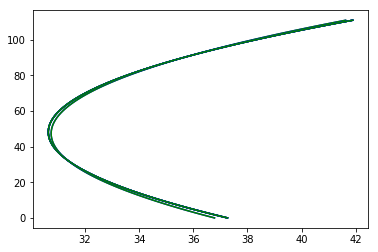

In [4]:
image = mpimg.imread("writeup_images//lanes_test_02.png")
image = as_gray(image) - 0.13119608
#plt.imshow(image)
#plt.show()

left_fit, right_fit, ploty, out_img = search_around_poly(image)

#plt.imshow(out_img)
#plt.show()

#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
#plt.imshow(image)
#plt.show()
left_fit, right_fit, ploty, out_img = search_around_poly(image, left_fit, right_fit)
plt.show()
#plt.imshow(out_img)

Here I paste all my utility functions that help me structure my code

In [18]:
def calibrate_camera(path_to_calibration_images):
    """
    Given a set of chessboard images taken by the same camera, this function generates correction values to mitigate
    the influence of the camera lense.
    
    :param path_to_calibration_images: Path to the images
    :return: A dict of the form: {'cam_matrix': mtx, 'distCoeffs': dist, 'rvecs': rvecs, 'tvecs': tvecs}
    See cv2.calibrateCamera() for more information about the parameters.
    
    """
    
    images = list_images(path_to_calibration_images)
    
    # Create the object points, which naturally form a grid
    objp= np.zeros((9*6,3),np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    imgpoints = []
    objpoints = []
    
    for image in images:
        img = mpimg.imread(image)
        gray = as_gray(img)
        # Find the corners of the chessboard patterns
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret:
            objpoints.append(objp)
            corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            imgpoints.append(corners2)
            
            # Draw and display the corners
            #print("draw")
            img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)
            #plt.imshow(img)
            #plt.show()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
         
    return {'cam_matrix': mtx, 'distCoeffs': dist, 'rvecs': rvecs, 'tvecs': tvecs}


def correct_lense(image_raw, lense_params):
    """
    This function takes the parameters learned from calibration and fixes the camera. 
    :param image_raw: The image which is still distorted
    :param lense_params: The parameters learned from "calibrate camera". Dict-like: {'cam_matrix': mtx, 'distCoeffs': dist, 'rvecs': rvecs, 'tvecs': tvecs}
    
    :return: Undistorted image
    """    
    return cv2.undistort(image_raw, 
                         lense_params['cam_matrix'], 
                         lense_params['distCoeffs'], 
                         None, 
                         lense_params['cam_matrix']
                         )


def find_lanes(image_bev, lanes_ring_buffer):
    """
    Runs the pipeline for finding lanes in a BEV tranformed image.
    :param image_bev: BEV transformed image
    :param lanes_ring_buffer: A ring buffer to hold the last found polys. Can be used to 
    average the result with the last N polys. i currently do not use this.
    
    :return: returns lanes dict and list of images.     lanes = {"left_fit" : left_fit,
             "right_fit" : right_fit,
             "ploty" : ploty}. The list of images is used for testing.
    """
    # Color transormation
    image_hls = cv2.cvtColor(image_bev, cv2.COLOR_RGB2HLS)
    image_luv = cv2.cvtColor(image_bev, cv2.COLOR_RGB2LUV)
        
    image_s = image_hls[:,:,2]
    image_h = image_hls[:,:,0]
    image_l = image_luv[:,:,0]
    image_b = image_bev[:,:,2]
    
    image_s_scaled = scale_distant_values(image_s, factor=2.0, order=1)
    image_s_scaled = smoothen(image_s_scaled)
    
    image_l_scaled = scale_distant_values(image_l, factor=1.25, order=1)
    image_l_scaled = smoothen(image_l_scaled)
    
    
    thresh_edge = (25, 255)
    thresh_s = (100, 255)
    thresh_h = (15, 100)
    thresh_l = (225, 255)
    thresh_b = (155, 200)
    
    binary_image_b = np.zeros_like(image_b)
    binary_image_b[(image_b > thresh_b[0]) & (image_b <= thresh_b[1])] = 1
    binary_image_b_opened = as_opened(binary_image_b)
    binary_image_b_opened_closed = as_closed(binary_image_b_opened, iterations=15)
    
    binary_image_l = np.zeros_like(image_l)
    binary_image_l[(image_l > thresh_l[0]) & (image_l <= thresh_l[1])] = 1
    binary_image_l_opened = as_opened(binary_image_l)
    binary_image_l_opened_closed = as_closed(binary_image_l_opened, iterations=15)
    
        
    binary_image_l_scaled = np.zeros_like(image_l_scaled)
    binary_image_l_scaled[(image_l_scaled > thresh_l[0]) & (image_l_scaled <= thresh_l[1])] = 1
    binary_image_l_scaled_opened = as_opened(binary_image_l_scaled)
    binary_image_l_scaled_opened_closed = as_closed(binary_image_l_scaled_opened, iterations=15)
    #print("binary_image_s_scaled_opened_closed dtype", binary_image_s_scaled_opened_closed.dtype)
    
    binary_image_s = np.zeros_like(image_s)
    binary_image_s[(image_s > thresh_s[0]) & (image_s <= thresh_s[1])] = 1
    binary_image_s_opened = as_opened(binary_image_s)
    binary_image_s_opened_closed = as_closed(binary_image_s_opened, iterations=15)
    #print("binary_image_s_opened_closed dtype", binary_image_s_opened_closed.dtype)
    
    
    binary_image_s_scaled = np.zeros_like(image_s_scaled)
    binary_image_s_scaled[(image_s_scaled > thresh_s[0]) & (image_s_scaled <= thresh_s[1])] = 1
    binary_image_s_scaled_opened = as_opened(binary_image_s_scaled)
    binary_image_s_scaled_opened_closed = as_closed(binary_image_s_scaled_opened, iterations=15)
    #print("binary_image_s_scaled_opened_closed dtype", binary_image_s_scaled_opened_closed.dtype)
    
    binary_image_h = np.zeros_like(image_h)
    binary_image_h[(image_h > thresh_h[0]) & (image_h <= thresh_h[1])] = 1
    binary_image_h_opened = as_opened(binary_image_h)
    binary_image_h_opened_closed = as_closed(binary_image_h_opened, iterations=15)
    # Edge detection
    #print("binary_image_h_opened_closed dtype", binary_image_h_opened_closed.dtype)

    image_edge = scale_distant_values(sobelx(as_gray(image_bev), ksize=11))
    image_edge = smoothen(image_edge)
    image_edge //= ((np.max(image_edge) // 255))
    binary_image_edge = np.zeros_like(image_edge)
    binary_image_edge[(image_edge > thresh_edge[0]) & (image_edge <= thresh_edge[1])] = 1
    binary_image_edge_opened = as_opened(binary_image_edge)
    binary_image_edge_opened_closed = as_closed(binary_image_edge_opened, iterations=15).astype("uint8")
    #print("binary_image_edge_opened_closed dtype", binary_image_edge_opened_closed.dtype)
    
    #as_3DPlot(as_fft(binary_image_edge_opened_closed_closed), "Edges 3D FFT")
    
    #Combine ALL good the binaries
    
    all_binaries = np.asarray([binary_image_edge_opened_closed, 
                    binary_image_s_opened_closed, 
                    binary_image_s_scaled_opened_closed,
                    binary_image_h_opened_closed,
                    binary_image_l_opened_closed,
                    binary_image_l_scaled_opened_closed
                   ])
    
    good_ones = [is_good_lanes(binary) for binary in all_binaries]
    #print("good_ones", good_ones)
    good_binaries = all_binaries[good_ones]
    #print("good_binaries", good_binaries)
    #print("len(good_binaries)", len(good_binaries))
    if good_binaries is not None:
        if len(good_binaries) > 1:
            combo = np.zeros_like(image_edge)
            combo = np.sum(np.stack(good_binaries, axis=-1), axis=2)
        elif len(good_binaries) == 1:
            combo = good_binaries[0]
        else:
            # Fall back in case no good one was found
            print("Fallback, no good solution found")
            combo = binary_image_edge_opened_closed
    
    #print(combo)
    # Now that a result is found, find polys on it
    # Testing only:
#    last_polys = {"left_fit" : None,
#                  "right_fit" : None,
#                  "ploty" : None}
    
    last_polys = lanes_ring_buffer.pop()
    
    #print("last_polys: ", last_polys)
    left_fit, right_fit, ploty, out_img = search_around_poly(binary_warped=combo, 
                                                             left_fit=last_polys['left_fit'], 
                                                             right_fit=last_polys['right_fit'])
    lanes = {"left_fit" : left_fit,
             "right_fit" : right_fit,
             "ploty" : ploty}
    
    is_sane, lanes = lane_sanity_filter(lanes, lanes_ring_buffer)
    if not is_sane:
        print("Found strange result, using last one!")
    
    lanes_ring_buffer.append(lanes)
    
    return lanes, [("Edges", image_edge),
                  ("Closed" , binary_image_edge_opened_closed),
                  ("Radon" , radon_clusters(as_radon_trafo(binary_image_edge_opened_closed), plot=True)),
        
                  ("L-Channel" , image_l),
                  ("Closed" , binary_image_l_opened_closed), 
                  ("Radon" , radon_clusters(as_radon_trafo(binary_image_l_opened_closed), plot=True)),
                  
                  ("L-Scaled" , image_l_scaled),
                  ("Closed" , binary_image_l_scaled_opened_closed), 
                  ("Radon" , radon_clusters(as_radon_trafo(binary_image_l_scaled_opened_closed), plot=True)),
                  
                  ("B-Channel" , image_b), 
                  ("Closed" , binary_image_b_opened_closed),
                  ("Radon" , radon_clusters(as_radon_trafo(binary_image_b_opened_closed), plot=True)),
                  
                  ("Combo", combo),
                  
                  ("Lanes", out_img)
                 ]
        
def transform_BEV(image_undistorted, img_size, offset, inverse=False):
    """
    This function transforms an image into a Birds Eye View(BEV). The raw image that is provided should already be undistorted.
    It returns a BEV representation of the image.
    
    :param image_undistorted: The image that shall be transformed 
    :param img_size: The size of the source image
    :param offset: an offset to the borders. This part will be omitted in the destination image
    :param inverse: If true, the function performs the inverse transformation from BEV into normal perspective.
    
    :return: Transformed image
    """
    src = trapezoid = np.float32([(569,450),(714,450),(1200,650), (100,650)])
    dst = np.float32([[offset, offset], 
                      [img_size[0]-offset, offset], 
                      [img_size[0]-offset, img_size[1]-offset], 
                      [offset, img_size[1]-offset]])
    
    # Swap if inverse is wanted
    if inverse:
        # print(src[0], dst[0])
        temp = np.copy(src)        
        src = dst
        dst = temp
        
        img_size = tuple(reversed(img_size))
        # print(src[0], dst[0])
        
    M = cv2.getPerspectiveTransform(src, dst)
    # print(img_size)
    return cv2.warpPerspective(image_undistorted, M, img_size)


def draw_lanes(lanes_ring_buffer):
    pass


def process_image_sequence(image_sequence, path_to_calibration_images):

    # Initialize data structures
    lanes_ring_buffer = collections.deque(maxlen=5)

    # Calibrate camera
    lense_params = calibrate_camera(path_to_calibration_images)

    if lense_params is None:
        return None

    for image in image_sequence:
        # process image
        image = correct_lense(image, lense_params)

        # BEV transformation
        image = transform_BEV(image)

        # Find lanes
        lanes = find_lanes(image, lanes_ring_buffer[-1])
        lanes_ring_buffer.append(lanes)

        # Draw lanes onto BEV-Image
        image = draw_lanes(lanes_ring_buffer)

        # Re-Transform image with lanes back
        image = re_transform_BEV(image)

        
def sobelx(img, ksize=5):
    """
    User defined wrapper for detecting x-wise edges only. I use it for extracting only lane-like edges 
    in the sobel output image.
    """
    return np.absolute(cv2.Sobel(img,cv2.CV_64F,2,0,ksize=ksize))


def draw_lanes_on_bev(image_bev, lanes):
    """
    Draw lane lines from dict to BEV image
    
    :param image_bev: Image to drw to 
    :param lanes: Lanes as dict
    
    :return: Returns blue polygon marking the found lane. 
    """
    
    left_fit = lanes["left_fit"]
    right_fit = lanes["right_fit"]
    ploty = lanes["ploty"]
    
    # Check if there is anything to draw, return input if not
    if left_fit is None or right_fit is None:
        return image_bev
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    line_pts = np.hstack((left_line, right_line)).astype(np.int32)
    
    #print("left_fitx", left_fitx)
    #print("right_fitx", right_fitx)
    
    pts = np.array([[10,5],[20,30],[70,20],[50,10]], np.int32)
    #print("pts", pts)
    #print(pts.shape)
    #left_pts = np.vstack([left_fitx, ploty]).T#reshape((-1, 2))
    #print("left_pts", left_pts)
    #print(left_pts.shape)
    #right_pts = np.flipud(np.vstack([right_fitx, ploty]).T)#reshape((-1, 2)))
    #print("right_pts", right_pts)
    #print(right_pts.shape)
    #all_pts = np.append(arr=left_pts, values=right_pts)
    #print("all_pts", all_pts)
    line_pts = line_pts.reshape((-1,1,2))
    pts = pts.reshape((-1,1,2))
    #print ("pts", pts)
    
    #print("line_pts", line_pts)
    return cv2.fillPoly(image_bev,np.int_([line_pts]),(0,255,255))


def get_position(lanes, img_mid):
    """
    Get the vehicle position relative the the road.
    
    :param lanes: Found lanes 
    :param img_mid: The mid point of the video image
    :return: offset in meters where >0 means right of  center and <0 left.
             offset_normed between -1 and 1. Same logic as above.
    """
    
    ploty, left_fit, right_fit = lanes['ploty'], lanes['left_fit'], lanes['right_fit']

    # Check if there is anything to measure, return None if not
    if left_fit is None or right_fit is None:
        return None, None
    
    y_eval = np.max(ploty)
    bottom_left_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    bottom_right_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]    
    
    mid = (bottom_left_x + bottom_right_x) / 2   
    
    offset = img_mid - mid
    
    # The offset should be normed between -1 and 1
    if mid == 0:
        mid = 0.00001
    
    # Converseion factor from pixels to meters
    xfactor = 7.5/720 # meters per pixel
    
    normed_offset = offset / mid
    meters_offset = offset * xfactor
    
    
    return normed_offset, meters_offset
    

def get_radius(lanes, normed_offset):
    """
    Calculates the curvature of the road by using the found lanes and the relative position of the vehicle in the lanes.
    Radius is return in meters, but is an approximation
    
    :param lanes: Found lanes 
    :param normed_offset: The normed offset

    :return: A readius value in meters 
    """
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit, right_fit = lanes['ploty'], lanes['left_fit'], lanes['right_fit']
    
        # Check if there is anything to draw, return input if not
    if left_fit is None or right_fit is None:
        return None
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Converseion factor from pixels to meters
    yfactor =380/1280 # meters per pixel in y dimension
    
    #y_eval*= yfactor
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Calculate average of both, taking the position of the vehicle into account   
    right_factor = normed_offset
    left_factor = 1 - normed_offset
    print("right_factor", right_factor)
    print("left_factor", left_factor)
    
    pixel_to_meters_correction_factor = 6.3
    radius = (left_curverad*left_factor + right_curverad*right_factor) / pixel_to_meters_correction_factor
    
    return radius


def lane_sanity_filter(lanes, last_lanes):
    """
    This function checks if found lanes are reasonable. 
    If yes, it returns a True and the found lanes.
    If no, it returns a FAlse and the previous lanes
    
    :param lanes: Found lanes
    :param last_lanes: A deque of the last few lanes
    
    :return: boolean if all is fine, and a set of last lanes
    """
    
    ploty, left_fit, right_fit = lanes['ploty'], lanes['left_fit'], lanes['right_fit']

    # Check if there is anything to measure, return None if not
    if left_fit is None or right_fit is None:
        return False, last_lanes.pop()
    
    
    # Three positions in lane to evaluate consistency
    y_evals = [np.max(ploty), np.max(ploty)//2, 0]
    dists = []
    for y in y_evals:
        left_x = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
        right_x = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
        # I use a simple distance metric
        dist = right_x - left_x
        print("Distance in x pixels: ", dist)
        dists.append(dist)
    
    print(np.std(dists))
    
    if not all(i >= 200 and i <= 500 for i in dists):
        # Distance are NOT all reasoanble
        return False, last_lanes.pop()
    elif not np.std(dists) <= 45:
        # The lines are not paralell enough to be lanes
        return False, last_lanes.pop()
    else:
        # Everything seems to be fine
        return True, lanes
    
    

In [6]:
list_images("test_images/")

['test_images/straight_lines1.jpg',
 'test_images/straight_lines2.jpg',
 'test_images/test1.jpg',
 'test_images/test2.jpg',
 'test_images/test3.jpg',
 'test_images/test4.jpg',
 'test_images/test5.jpg',
 'test_images/test6.jpg']

## Test calibration and undistortion

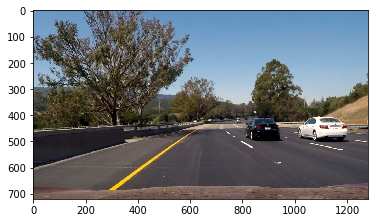

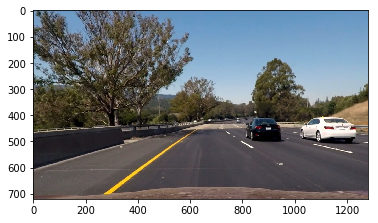

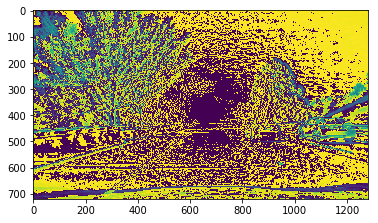

In [7]:
list_images("camera_cal/")
params = calibrate_camera("camera_cal/")

raw = mpimg.imread("test_images/test6.jpg")
plt.imshow(raw)
plt.show()
result = correct_lense(raw, params)
plt.imshow(result)
plt.show()

gray_raw = as_gray(raw)
result_gray = as_gray(result)

diff = gray_raw - result_gray
plt.imshow(diff)
plt.show()

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

## Build a Lane Finding Pipeline



Here I let the pipeline run for each test image and plot the result in a table like overview image. The Writeup contains many of these.

deque([{'left_fit': None, 'right_fit': None, 'ploty': None}, {'left_fit': None, 'right_fit': None, 'ploty': None}, {'left_fit': None, 'right_fit': None, 'ploty': None}, {'left_fit': None, 'right_fit': None, 'ploty': None}, {'left_fit': None, 'right_fit': None, 'ploty': None}], maxlen=5)
Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.
Distance in x pixels:  383.4805518387877
Distance in x pixels:  386.50185914542647
Distance in x pixels:  383.5477984982184
1.408675274533441
Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Expected n_neighbors > 0. Got 0
bandwidth needs to be greater than zero or None,            got 0.000000
Distance in x pixels:  380.13449611509685
Distance in x pixels:  397.7725793793262
Distance in x pixels:  387.7735901357569
7.222168992341
bandwidth needs to be greater than zero or None,            got 0.000000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.
Distance in x pixels:  359.2524468944331
Distance in x pixels:  409.00237318762174
Distance in x pixels:  427.82979968152335
28.929762586585863
Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.
Distance in x pixels:  357.8235381041661
Distance in x pixels:  415.35823668958875
Distance in x pixels:  491.0089657311346
54.540130462716554
Found strange result, using last one!
Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.
Distance in x pixels:  386.8989749078152
Distance in x pixels:  397.9867122649571
Distance in x pixels:  447.874405015971
26.5198518610642
Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.
Distance in x pixels:  373.9139780682046
Distance in x pixels:  408.8668238206489
Distance in x pixels:  443.786633414843
28.525393158219668
Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.
Distance in x pixels:  429.01752470190934
Distance in x pixels:  427.64170389045177
Distance in x pixels:  470.4661948603581
19.87131424284404
Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.
Distance in x pixels:  370.2746005631926
Distance in x pixels:  415.99514174713227
Distance in x pixels:  444.93850436230775
30.73684841819773
Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


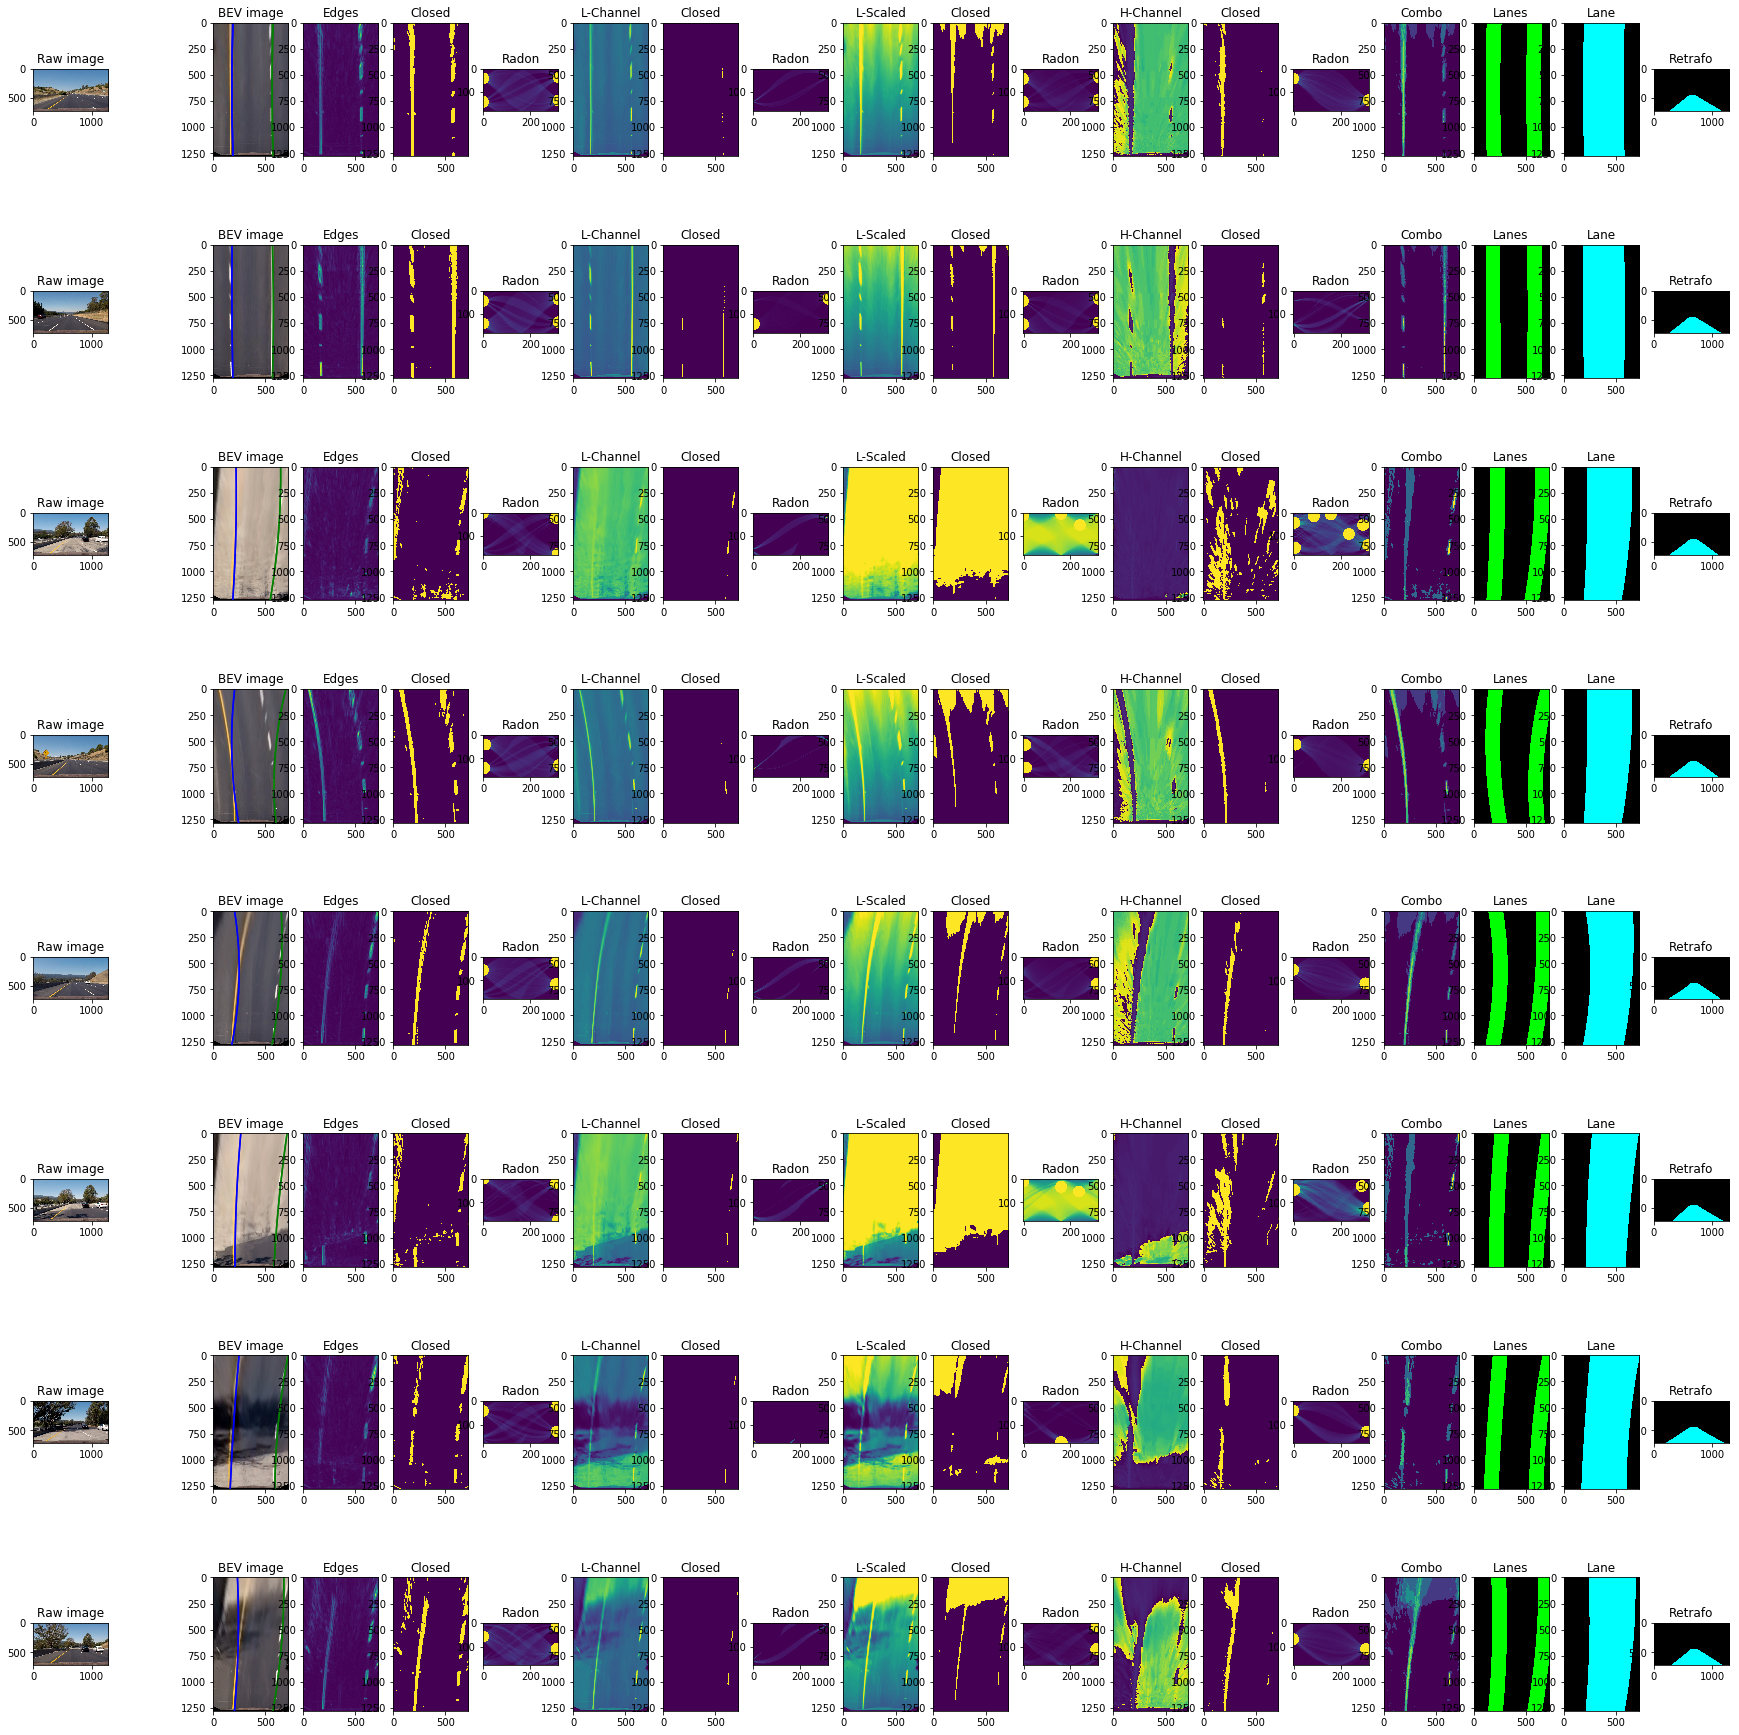

In [19]:
# Iterate over all test_images and output them in a grid
w=10
h=10
fig=plt.figure(figsize=(32, 32))
columns = 3 + 17
rows = len(list_images("test_images/"))
# Initialize data structures
lanes_ring_buffer = collections.deque(maxlen=5)
for i in range(5):
    lanes_ring_buffer.append({"left_fit" : None,
                              "right_fit" : None,
                              "ploty" : None})
print(lanes_ring_buffer)

camera_params = calibrate_camera("camera_cal/")

for row, file in enumerate(list_images("test_images/")):

    image_raw = mpimg.imread(file)
    
    fig.add_subplot(rows, columns, row*columns+1).set_title('Raw image')
    plt.imshow(image_raw)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

    # process image
    image_undist = correct_lense(image_raw, camera_params)
    
    # BEV transformation
    imsize = (image_raw.shape[0], image_raw.shape[1])    
    image_bev = transform_BEV(image_undist, img_size=imsize, offset=50)
    
    fig.add_subplot(rows, columns, row*columns+3).set_title('BEV image')
    plt.imshow(image_bev)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    
    # Find lanes
    lanes, dev_images = find_lanes(image_bev, lanes_ring_buffer)
    lanes_ring_buffer.append(lanes)
    
    # Plot intermediates
    start_column = 4
    for col, title_image in enumerate(dev_images):
        col += start_column
        title, image = title_image
        fig.add_subplot(rows, columns, row*columns+col).set_title(title)
        plt.imshow(image)
    
    # Draw lanes onto BEV-Image
    # Create background
    background = np.zeros_like(image_bev[:,:,0]).astype(np.uint8)
    background = np.dstack((background, background, background))
    
    draw_lanes_on_bev(background, lanes)
    fig.add_subplot(rows, columns, row*columns+col+1).set_title("Lane")
    plt.imshow(background)

    back_trafo = transform_BEV(background, img_size=imsize, offset=50, inverse=True)
    fig.add_subplot(rows, columns, row*columns+col+2).set_title("Retrafo")
    plt.imshow(back_trafo)
    #image = draw_lanes(lanes_ring_buffer)

    # Re-Transform image with lanes back
    #image = re_transform_BEV(image)


## Test on Video

Here I load the video and test the performance.

* `project_video.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
lanes_ring_buffer = collections.deque(maxlen=2)
for i in range(2):
    lanes_ring_buffer.append({"left_fit" : None,
                              "right_fit" : None,
                              "ploty" : None})
    
camera_params = calibrate_camera("camera_cal/")
font = cv2.FONT_HERSHEY_SIMPLEX 
np.set_printoptions(precision=2)
def process_image(image):
    """
    Applies complete pipeline to an image.
    
    :param image: Image 
    :return: Same image with marked lane
    """    
    # Undistort
    image_undist = correct_lense(image, camera_params)
    
    # BEV transformation
    imsize = (image.shape[0], image.shape[1])    
    image_bev = transform_BEV(image_undist, img_size=imsize, offset=50)
    
    # Find lanes. _ are the intermediate images for testing
    lanes, _ = find_lanes(image_bev, lanes_ring_buffer)
    
    lanes_ring_buffer.append(lanes)
    
    # Create background
    background = np.zeros_like(image_bev[:,:,0]).astype(np.uint8)
    background = np.dstack((background, background, background))
    
    draw_lanes_on_bev(background, lanes)
    #plt.imshow(background)
    #plt.show()
    back_trafo = transform_BEV(background, img_size=imsize, offset=50, inverse=True)
    
    # Combine the result with the original image

    back_trafo = back_trafo.reshape((image.shape[0], image.shape[1], 3))
    #plt.imshow(back_trafo)
    #plt.show()
    #print(image.shape)
    #print(back_trafo.shape)
    result = cv2.addWeighted(image, 1, back_trafo, 0.3, 0)
    
    offset_normed, offset_meters = get_position(lanes, image.shape[0] // 2)

    if offset_normed is not None:
        radius = get_radius(lanes, offset_normed)
    
        radius_str = "Radius of road = {:.2f}".format(radius) + "m"
        position_str = "Vehicle is "
        if offset_meters > 0:
            position_str += ("{:.2f}".format(abs(offset_meters)) + " m to the right of center")
        else:
            position_str += ("{:.2f}".format(abs(offset_meters)) + "m to the left of center")

    else:
        radius_str = "No lanes found!"
        position_str = "No lanes found!"

    cv2.putText(result, radius_str,(40,60), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result, position_str,(40,140), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    
    plt.imshow(result)
    plt.show()
    
    return result

Distance in x pixels:  384.38697923841653
Distance in x pixels:  385.8886489541816
Distance in x pixels:  384.69517855918406
0.647591292603511
right_factor -0.048708491129070934
left_factor 1.048708491129071


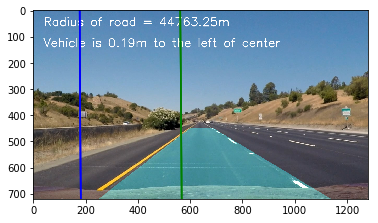

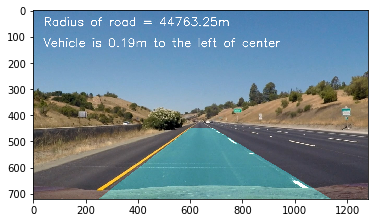

Expected n_neighbors > 0. Got 0
bandwidth needs to be greater than zero or None,            got 0.000000
Distance in x pixels:  382.7999302125304
Distance in x pixels:  395.97291461587315
Distance in x pixels:  395.1860130446315
6.032889303155977
Expected n_neighbors > 0. Got 0
bandwidth needs to be greater than zero or None,            got 0.000000
right_factor -0.048467610443718605
left_factor 1.0484676104437185


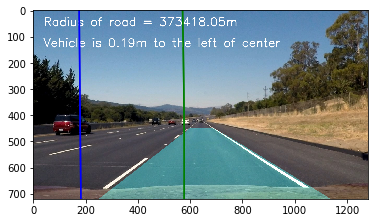

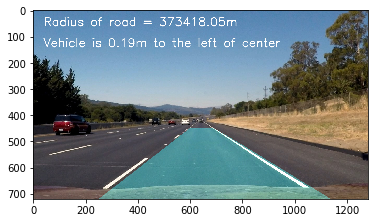

Distance in x pixels:  360.6661267393059
Distance in x pixels:  408.66025008994217
Distance in x pixels:  431.68053637515186
29.583057900646125
right_factor -0.019701000702352967
left_factor 1.019701000702353


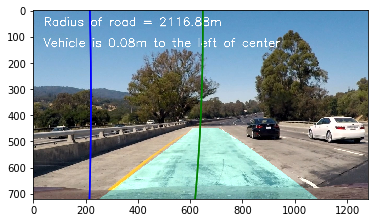

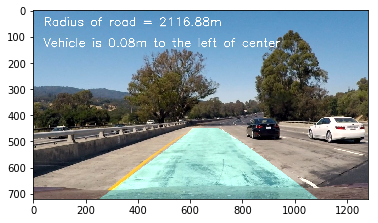

Distance in x pixels:  376.04847006705637
Distance in x pixels:  402.4417798603189
Distance in x pixels:  516.8198793842025
61.09695949306412
Found strange result, using last one!
right_factor -0.019701000702352967
left_factor 1.019701000702353


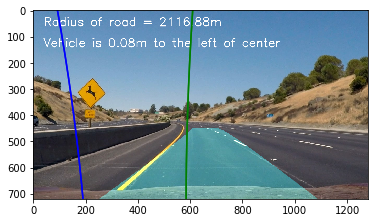

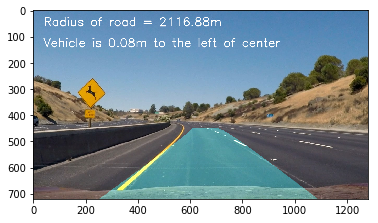

Distance in x pixels:  390.0484228454469
Distance in x pixels:  385.7797720817408
Distance in x pixels:  407.2551101603011
9.28249016686863
right_factor -0.07772971600836293
left_factor 1.077729716008363


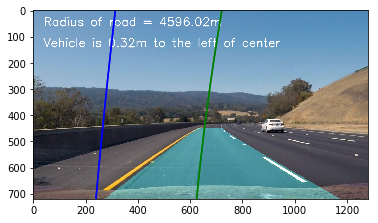

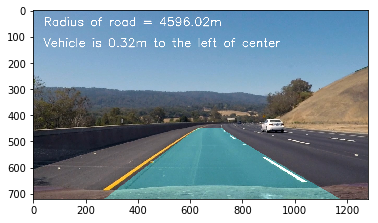

Distance in x pixels:  374.7496055648109
Distance in x pixels:  407.66637456421165
Distance in x pixels:  437.09935284908886
25.46741900828344
right_factor -0.09813500145892567
left_factor 1.0981350014589257


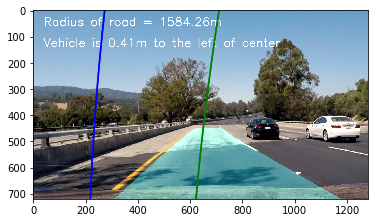

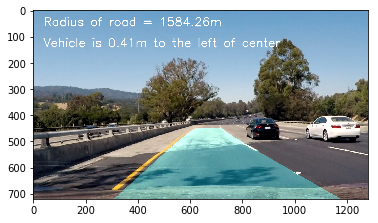

Distance in x pixels:  429.1373002846534
Distance in x pixels:  427.66074479044215
Distance in x pixels:  470.4661521208386
19.839794765252304
right_factor -0.04765382031792335
left_factor 1.0476538203179233


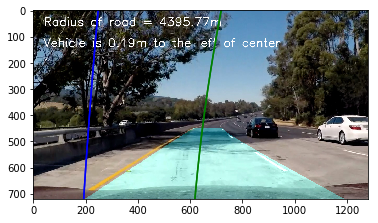

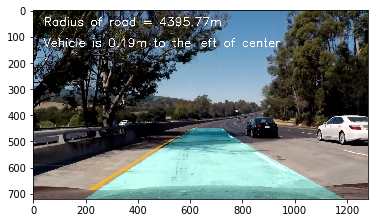

Distance in x pixels:  383.3381030836548
Distance in x pixels:  410.87855383258466
Distance in x pixels:  468.20274493662805
35.34991238401925
right_factor -0.08286174136419586
left_factor 1.0828617413641959


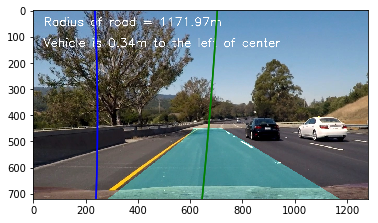

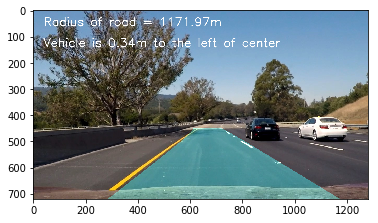

In [13]:
images = [mpimg.imread(i) for i in list_images("test_images/")]

for i in images:
    plt.imshow(process_image(i))
    plt.show()

Now I try it with the video:

In [ ]:
white_output = 'project_video_trans.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip("project_video.mp4")


white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
                            
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))